In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [562]:
data = pd.read_csv('raw_ltv.csv', sep=';', parse_dates=['Date', 'InstallationTimestamp']).drop(columns=['Unnamed: 0'])
data

,id,Date,UserId,InstallationTimestamp,PurchaseSystem,PurchaseAmount,TransactionId,Country,OsVersion,Variant,cohort,experimentVariant
0,747049,2019-09-13,140ea12d-330c-4fa5-9802-8514c245fc7c,2019-09-13,PP,"1,95",205E254331J,GB,Microsoft Windows 10 Home,C,CD-2019-09-13,control
1,747096,2019-09-13,bb34214d-a417-495c-bf7e-4b1153d4047f,2019-09-13,PP,"1,95",50B49680618,SG,Microsoft Windows 10 Pro,C,CD-2019-09-13,control
2,747149,2019-09-13,8ffcfa7c-3fc4-4b5b-8267-46e3f8b903ef,2019-09-13,St,"1,95",pVWk30210NpQ,JP,Microsoft Windows 10 Home,C,CD-2019-09-13,control
3,747171,2019-09-13,91ec5e23-95c4-4a66-bf23-38f21a189989,2019-09-13,St,"60,95",IDzTFyqKxDMIE9a1W1p,US,Microsoft Windows 10 Home,C,CD-2019-09-13,control
4,747184,2019-09-13,7351fc26-2d04-499b-aa05-462a87377960,2019-09-13,St,"1,95",pmnYofyldPOj,NL,Microsoft Windows 10 Home,D,CD-2019-09-13,test
...,...,...,...,...,...,...,...,...,...,...,...,...
11027,810397,2019-10-24,37490ed1-3731-466d-95fe-f330ea6361e3,2019-09-25,St,"5,95",UsBMeXHMVyz5,AR,Microsoft Windows 7 Ultimate,E,EF-2019-09-20,control
11028,810294,2019-10-24,846413db-3cb0-4bc0-b80f-438f411cd909,2019-09-18,St,"10,95",q9A9BGhFASQJ,JP,Microsoft Windows 10 Home,D,CD-2019-09-13,test
11029,810339,2019-10-24,b10eb8a7-3730-426a-ad5f-462055d4a5a0,2019-09-18,St,"10,95",qpkSdECISjfK,JP,Microsoft Windows 8.1,D,CD-2019-09-13,test
11030,810362,2019-10-24,0ecb354e-f028-4610-becb-2bf9740c2179,2019-09-18,St,"10,95",rU7EbujDLtlu,US,Microsoft Windows 7 Ultimate,D,CD-2019-09-13,test


In [567]:
data.PurchaseAmount = data.PurchaseAmount.apply(lambda x: '.'.join(x.split(','))).astype(float)

In [125]:
w = data.merge(data.groupby(['UserId']).size().reset_index(name='counts'), on='UserId').drop_duplicates(subset='UserId')
print(f"Процент людей, продливших подписку за новую цену: {w[w.counts > 1].counts.size / w.counts.size * 100}")
print(f"Процент людей, продливших подписку за новую цену в контрольной когорте: {w[(w.counts > 1) & (w.experimentVariant == 'control')].counts.size / w[w.experimentVariant == 'control'].counts.size * 100}")
print(f"Процент людей, продливших подписку за новую цену в тестовой когорте: {w[(w.counts > 1) & (w.experimentVariant == 'test')].counts.size / w[w.experimentVariant == 'test'].counts.size * 100}")

Процент людей, продливших подписку за новую цену: 41.43846915209502
Процент людей, продливших подписку за новую цену в контрольной когорте: 41.76565008025682
Процент людей, продливших подписку за новую цену в тестовой когорте: 41.09263657957244


<BarContainer object of 3 artists>

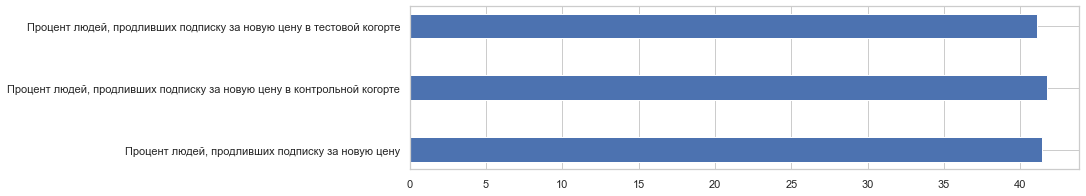

In [272]:
labels = ['Процент людей, продливших подписку за новую цену', 
                              'Процент людей, продливших подписку за новую цену в контрольной когорте', 
                              'Процент людей, продливших подписку за новую цену в тестовой когорте']

fig, ax = plt.subplots(figsize=(12,3))
sns.set_theme(style="whitegrid")
plt.barh(labels, [w[w.counts > 1].counts.size / w.counts.size * 100,
                w[(w.counts > 1) & (w.experimentVariant == 'control')].counts.size / w[w.experimentVariant == 'control'].counts.size * 100,
                w[(w.counts > 1) & (w.experimentVariant == 'test')].counts.size / w[w.experimentVariant == 'test'].counts.size * 100], height=0.4)

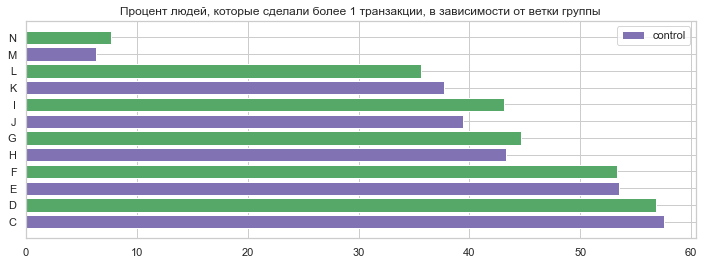

In [504]:
ww = data.merge(data.groupby(['experimentVariant', 'Variant', 'UserId']).size().reset_index(name='counts'), on=['experimentVariant', 'Variant', 'UserId']).drop_duplicates(subset='UserId')
labels = ww.Variant.unique()

fig, ax = plt.subplots(figsize=(12,4))
sns.set_theme(style="whitegrid")
plt.barh(labels, [ww[(ww.counts > 1) & (ww.Variant == label)].counts.size / ww[ww.Variant == label].counts.size * 100 for label in labels], 
         height=0.8, color=['m','g']*6, label ='control')
plt.title('Процент людей, которые сделали более 1 транзакции, в зависимости от ветки группы')
plt.legend()

Text(0.5, 1.0, 'Количество пользователей в каждой ветке')

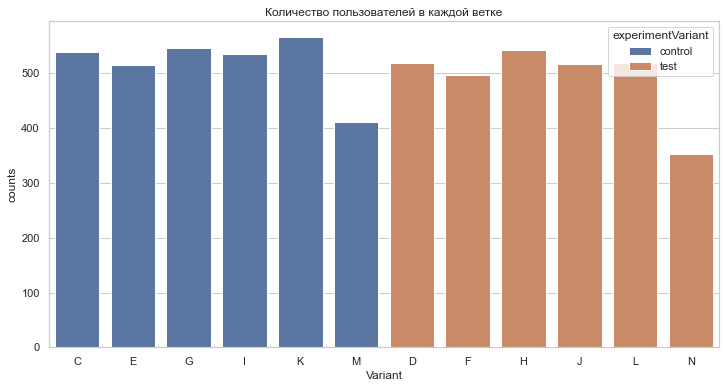

In [502]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x="Variant", y="counts", hue="experimentVariant",
                 data=data.drop_duplicates(subset='UserId').groupby(['experimentVariant', 'Variant']).size().reset_index(name='counts'), dodge=False, saturation=0.7, ax=ax)
ax.set_title('Количество пользователей в каждой ветке')

In [409]:
import researchpy as rp

print(rp.summary_cont(data[data.experimentVariant == 'control'].PurchaseAmount))
print(rp.summary_cont(data[data.experimentVariant == 'test'].PurchaseAmount))



         Variable       N   Mean       SD      SE  95% Conf.  Interval
0  PurchaseAmount  5671.0  9.376  16.0585  0.2132      8.958     9.794


         Variable       N     Mean       SD      SE  95% Conf.  Interval
0  PurchaseAmount  5361.0  11.5749  16.2783  0.2223    11.1391   12.0108


Интересно, что стандартное отклонение примерно одинаковое

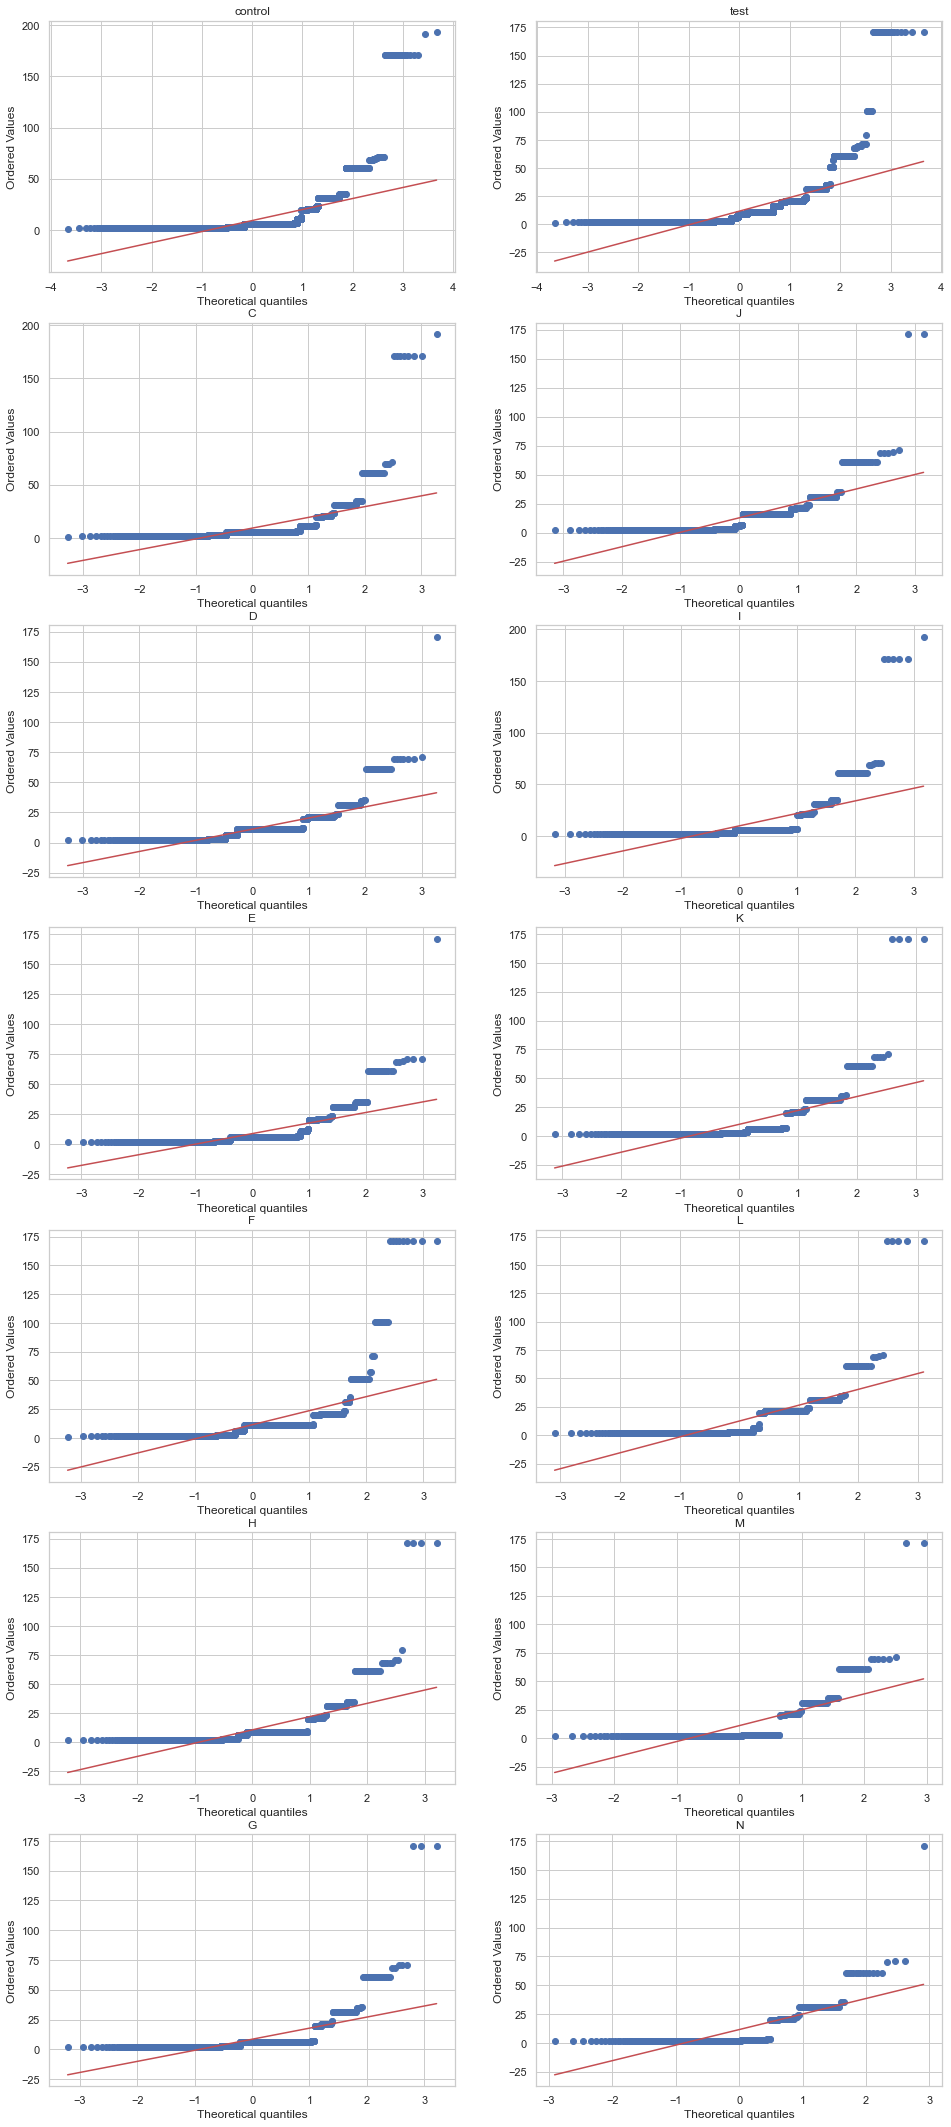

In [637]:
fig, ax = plt.subplots(7,2, figsize=(16,38))

stats.probplot(data[data.experimentVariant == 'control'].PurchaseAmount, dist="norm", plot=ax[0][0])
stats.probplot(data[data.experimentVariant == 'test'].PurchaseAmount, dist="norm", plot=ax[0][1])
ax[0][0].set_title('control')
ax[0][1].set_title('test')

for i in range(1, 7):
    stats.probplot(data[data.Variant == f'{data.Variant.unique()[i-1]}'].PurchaseAmount, dist="norm", plot=ax[i][0])
    ax[i][0].set_title(f'{data.Variant.unique()[i-1]}')
    stats.probplot(data[data.Variant == f'{data.Variant.unique()[i+5]}'].PurchaseAmount, dist="norm", plot=ax[i][1])
    ax[i][1].set_title(f'{data.Variant.unique()[i+5]}')

Видим, что мы имеем далеко не нормальное распределение и в группах и в ветках.

In [389]:
print("Control group")
stat, p = stats.normaltest(data[data.experimentVariant == 'control'].PurchaseAmount) # Критерий согласия Пирсона
print("Statistics=%.3f, p-value=%.3f" % (stat, p))
if p > 0.05:
    print('Принять гипотезу о нормальности')
else:
    print("Отклонить гипотезу о нормальности\n")
    
print("Test group")
stat, p = stats.normaltest(data[data.experimentVariant == 'test'].PurchaseAmount) # Критерий согласия Пирсона
print("Statistics=%.3f, p-value=%.3f" % (stat, p))
if p > 0.05:
    print('Принять гипотезу о нормальности')
else:
    print("Отклонить гипотезу о нормальности\n")

Control group
Statistics=6243.622, p-value=0.000
Отклонить гипотезу о нормальности

Test group
Statistics=5479.020, p-value=0.000
Отклонить гипотезу о нормальности



Получили, что распределения суммы выплат по группам не является нормальным

In [127]:
data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('mean')

experimentVariant  Variant
control            C           9.282189
                   E           8.871508
                   G           8.475600
                   I           9.802201
                   K          10.053080
                   M          11.061452
test               D          11.134419
                   F          11.506083
                   H          10.722911
                   J          12.650253
                   L          12.425533
                   N          11.608298
Name: PurchaseAmount, dtype: float64

In [154]:
data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('median')

experimentVariant  Variant
control            C           5.9500
                   E           5.9500
                   G           5.9500
                   I           5.9500
                   K           2.9500
                   M           2.0925
test               D          10.9500
                   F          10.9500
                   H           8.9500
                   J           5.9500
                   L           2.9500
                   N           2.0925
Name: PurchaseAmount, dtype: float64

Text(0.5, 1.0, 'Количество транзакций пользователей в каждой ветке когорты')

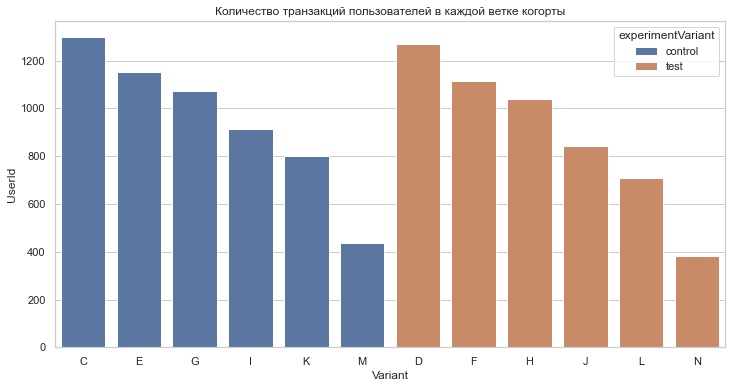

In [245]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x="Variant", y="UserId", hue="experimentVariant",
                 data=data.groupby(['experimentVariant', 'Variant']).UserId.agg('count').reset_index(), dodge=False, saturation=0.7, ax=ax)
plt.title('Количество транзакций пользователей в каждой ветке когорты')

Text(0.5, 1.0, 'Распределение PurchaseAmount в тестовой группе')

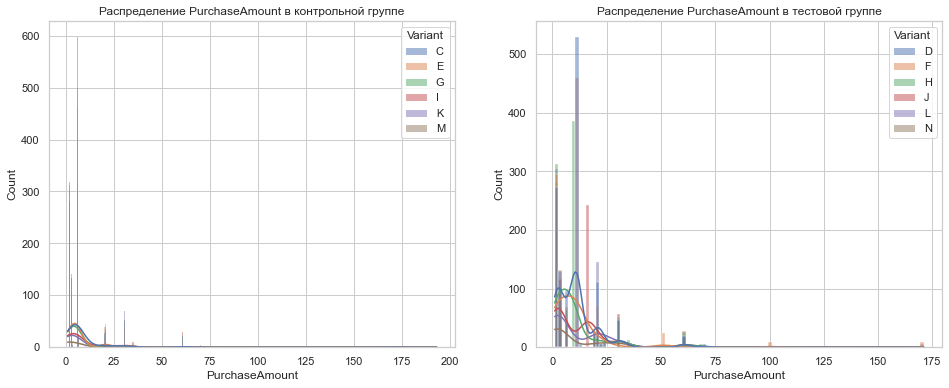

In [317]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(data[data.experimentVariant == 'control'], x='PurchaseAmount', hue='Variant', kde=True, ax=ax[0])
sns.histplot(data[data.experimentVariant == 'test'], x='PurchaseAmount', hue='Variant', kde=True, ax=ax[1])
ax[0].set_title('Распределение PurchaseAmount в контрольной группе')
ax[1].set_title('Распределение PurchaseAmount в тестовой группе')

Text(0.5, 1.0, 'Медианные значения PurchaseAmount по группам')

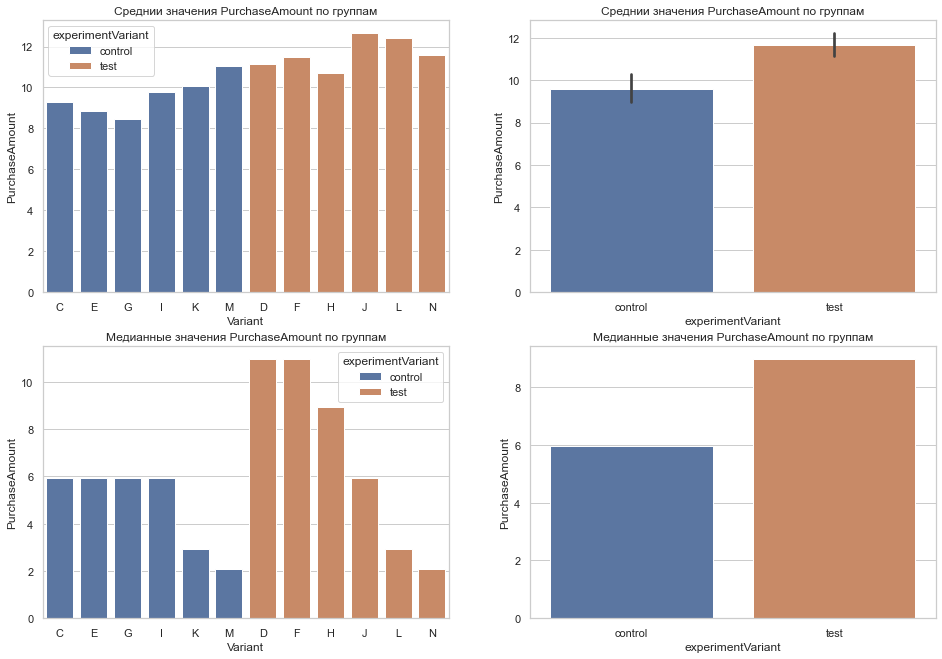

In [339]:
fig, ax = plt.subplots(2,2,figsize=(16,11))

sns.barplot(x="Variant", y="PurchaseAmount", hue="experimentVariant",
                 data=data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('mean').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[0][0])
sns.barplot(x="Variant", y="PurchaseAmount", hue="experimentVariant",
                 data=data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('median').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[1][0])

sns.barplot(x="experimentVariant", y="PurchaseAmount", 
                 data=data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('mean').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[0][1])
sns.barplot(x="experimentVariant", y="PurchaseAmount", 
                 data=data.groupby(['experimentVariant']).PurchaseAmount.agg('median').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[1][1])

ax[0][0].set_title('Среднии значения PurchaseAmount по группам')
ax[1][0].set_title('Медианные значения PurchaseAmount по группам')
ax[0][1].set_title('Среднии значения PurchaseAmount по группам')
ax[1][1].set_title('Медианные значения PurchaseAmount по группам')

In [413]:
print(stats.f_oneway(data[data.experimentVariant == 'control'].PurchaseAmount.values, data[data.experimentVariant == 'test'].PurchaseAmount.values))

F_onewayResult(statistic=50.99048951726153, pvalue=9.86561077576856e-13)


In [434]:
MultiComp = MultiComparison(data['PurchaseAmount'],
                            data['experimentVariant'])
MultiComp.tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control,test,2.1989,0.001,1.5953,2.8026,True


Получили, что средние в контрольной и тестовой группах статистически значимо отличаются. Выбросов много. В таком случае лучше применять дисперсионный анализ по Краскелу-Уоллису, где нулевая гипотеза про равенства медиан, а не средних

In [435]:
print(stats.kruskal(data[data.experimentVariant == 'control'].PurchaseAmount.values, data[data.experimentVariant == 'test'].PurchaseAmount.values))

KruskalResult(statistic=155.4297639785754, pvalue=1.1279191839481899e-35)


Получили, что средние и медианы в контрольной и тестовой группах статистически значимо отличаются.

Теперь стоит проверить, изменение цены ли дало такой результат. Проверим ветки.

In [397]:
group1 = data[data.Variant == 'C'].PurchaseAmount
group2 = data[data.Variant == 'D'].PurchaseAmount
group3 = data[data.Variant == 'E'].PurchaseAmount
group4 = data[data.Variant == 'F'].PurchaseAmount
group5 = data[data.Variant == 'G'].PurchaseAmount
group6 = data[data.Variant == 'H'].PurchaseAmount
group7 = data[data.Variant == 'I'].PurchaseAmount
group8 = data[data.Variant == 'J'].PurchaseAmount
group9 = data[data.Variant == 'K'].PurchaseAmount
group10 = data[data.Variant == 'L'].PurchaseAmount
group11 = data[data.Variant == 'M'].PurchaseAmount
group12 = data[data.Variant == 'N'].PurchaseAmount

(W,p) = stats.levene(group1, group2, group3,group4, group5, group6, group7, group8, group9, group10, group11, group12)
print("W {}, p {}".format(W,p))

W 11.383379433735017, p 2.185114264099849e-21


In [411]:
print(stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11, group12))

F_onewayResult(statistic=6.535319559724469, pvalue=5.838219029155681e-11)


Это было и так видно, но мы убедились, что хотя бы одна ветка статистически значимо отличается

In [419]:
df = pd.DataFrame({'group1': pd.Series(group1.values),
    'group2': pd.Series(group2.values), 
    'group3': pd.Series(group3.values),
    'group4': pd.Series(group4.values),
    'group5': pd.Series(group5.values),
    'group6': pd.Series(group6.values), 
    'group7': pd.Series(group7.values),
    'group8': pd.Series(group8.values),
    'group9': pd.Series(group9.values),
    'group10': pd.Series(group10.values), 
    'group11': pd.Series(group11.values),
    'group12': pd.Series(group12.values)})

In [433]:
MultiComp = MultiComparison(data['PurchaseAmount'],
                            data['Variant'])
MultiComp.tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
C,D,1.8522,0.1385,-0.2316,3.9361,False
C,E,-0.4107,0.9,-2.5483,1.7269,False
C,F,2.2239,0.0362,0.068,4.3797,True
C,G,-0.8066,0.9,-2.9862,1.373,False
C,H,1.4407,0.5778,-0.756,3.6374,False
C,I,0.52,0.9,-1.7613,2.8014,False
C,J,3.3681,0.001,1.0325,5.7036,True
C,K,0.7709,0.9,-1.6025,3.1442,False
C,L,3.1433,0.0018,0.6786,5.6081,True
C,M,1.7793,0.6735,-1.1412,4.6998,False


<AxesSubplot:xlabel='Variant', ylabel='PurchaseAmount'>

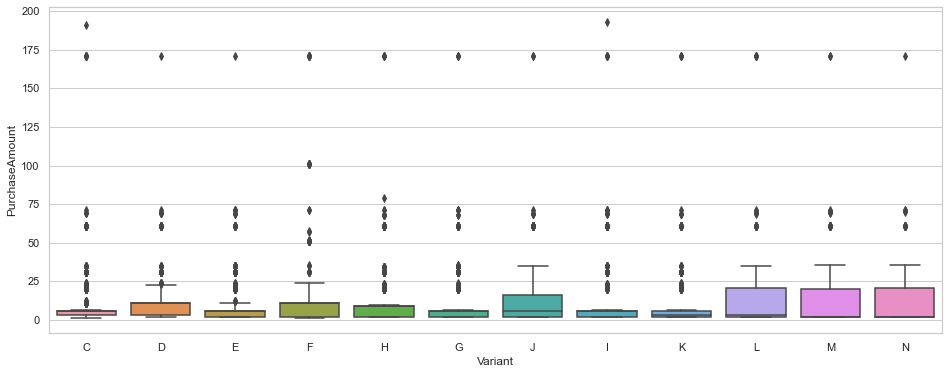

In [429]:
fig, ax = plt.subplots(figsize=(16,6))
sns.boxplot(data=data, x='Variant', y='PurchaseAmount', dodge=False, ax=ax)

Видим, что у нас очень много выбросов. Это говорит о не гомогенности дисперсий. Можно применить тест Левена.

In [823]:
stats.levene(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11, group12)

LeveneResult(statistic=11.383379433735017, pvalue=2.185114264099849e-21)

Дисперсии не гомогенны. В таком случае лучше применять дисперсионный анализ по Краскелу-Уоллису.

In [824]:
stats.kruskal(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11, group12)

KruskalResult(statistic=350.8498128760045, pvalue=1.6021560828893258e-68)

Получили аналогичный результат. Мы отвергаем нулевую гипотезу о равенстве средних и медиан в ветках.

Посмотрим на другие признаки

                     Source            SS       DF          MS             F  \
0                   Variant -2.808796e-04     11.0   -0.000026 -9.805892e-08   
1            PurchaseSystem -1.582514e-05      2.0   -0.000008 -3.038626e-08   
2  Variant * PurchaseSystem  4.089894e+03     22.0  185.904291  7.139191e-01   
3                  Residual  2.863615e+06  10997.0  260.399660           NaN   

      p-unc           np2  
0  1.000000 -9.808567e-11  
1  1.000000 -5.526281e-12  
2  0.398164  1.426191e-03  
3       NaN           NaN  


C:\Users\zapro\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 1
  warnings.warn('covariance of constraints does not have full '


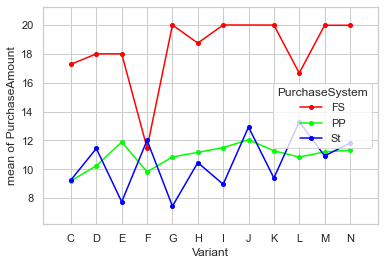

In [440]:
import pingouin as pg
from statsmodels.graphics.factorplots import interaction_plot
 
fig = interaction_plot(data.Variant, data.PurchaseSystem, data.PurchaseAmount, ms=8)
aov = pg.anova(dv='PurchaseAmount', between=['Variant', 'PurchaseSystem'], data=data, detailed=True)
print(aov)

Видим, что и PurchaseSystem как-то коррелирует с ценой подписки. Самые дорогие подписки в среднем проходили на FS.

А может мы получаем больше профита благодаря тому, что не отбалансировали группы по PurchaseSystem? Проверим!

Text(0.5, 1.0, 'Относительно количество транзакций с каждой системы по веткам')

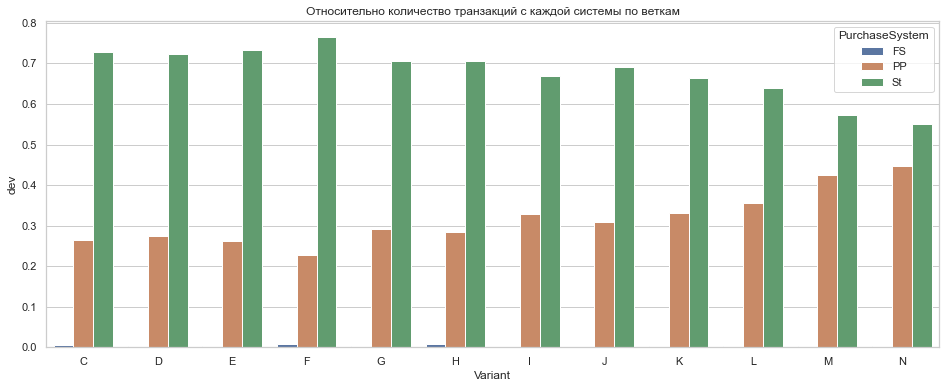

In [697]:
r = data.groupby(['Variant', 'PurchaseSystem']).PurchaseSystem.size().reset_index(name='counts').merge(data.groupby(['Variant']).size().reset_index(name='counts_var'), on='Variant')
r['dev'] = r.counts/r.counts_var

fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="Variant", y="dev", hue='PurchaseSystem',
                 data=r, dodge=True, saturation=0.7, ax=ax)
ax.set_title('Относительно количество транзакций с каждой системы по веткам')

Из этого графика и графиков выше видно, что уменьшение медианного значения суммы покупки может быть связано с уменьшением системы оплаты St и увеличение PP. На среднее значение это никак не влияет.

Text(0.5, 1.0, 'Относительно количество транзакций с каждой системы по группам')

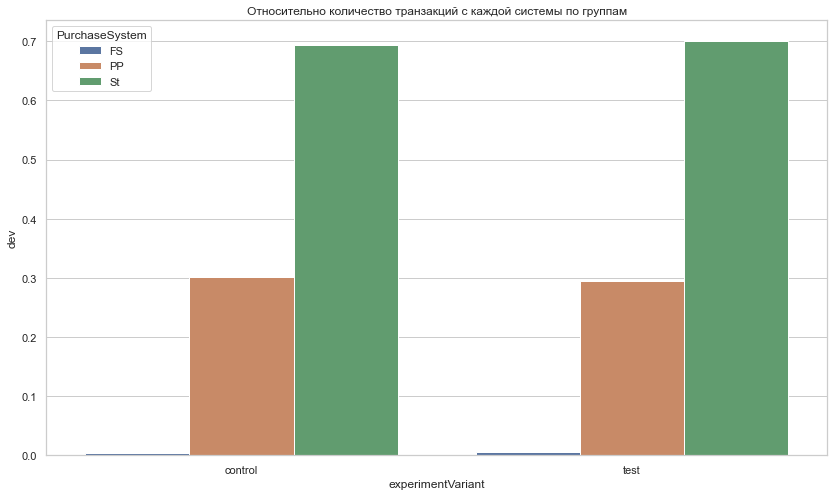

In [698]:
r = data.groupby(['experimentVariant', 'PurchaseSystem']).PurchaseSystem.size().reset_index(name='counts').merge(data.groupby(['experimentVariant']).size().reset_index(name='counts_var'), on='experimentVariant')
r['dev'] = r.counts/r.counts_var

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(x="experimentVariant", y="dev", hue='PurchaseSystem',
                 data=r, dodge=True, saturation=0.7, ax=ax)
ax.set_title('Относительно количество транзакций с каждой системы по группам')

Оказывается, по группа разбили хорошо в относительно систем оплаты.

Заметим, что наиболее прибыльная система реже всех встречается во всех ветках. Скорее всего, средняя перекошена из-за маленькой выборки этих значений и больших значений.

Можно это проверить, посмотрев медианы, хотя в случае малости выборки это не информативно.

In [463]:
print(stats.kruskal(data[data.PurchaseSystem == 'FS'].PurchaseAmount, data[data.PurchaseSystem == 'PP'].PurchaseAmount, data[data.PurchaseSystem == 'St'].PurchaseAmount))

KruskalResult(statistic=57.35650633693827, pvalue=3.50907700182287e-13)


In [591]:
print(stats.f_oneway(data[data.PurchaseSystem == 'FS'].PurchaseAmount, data[data.PurchaseSystem == 'PP'].PurchaseAmount, data[data.PurchaseSystem == 'St'].PurchaseAmount))

F_onewayResult(statistic=6.029794028027715, pvalue=0.0024139284177300156)


Получили, что система оплаты вносит существенного вклад в среднее и медианное значения суммы оплаты. Но мы видим, что в группах имеется примерно одинаковое количество транзакций с этих систем, поэтому вряд ли это повлияло на сдвиг среднего суммы выплат по группам.

In [465]:
print("FS", rp.summary_cont(data[data.PurchaseSystem == 'FS'].PurchaseAmount))
print("PP", rp.summary_cont(data[data.PurchaseSystem == 'PP'].PurchaseAmount))
print("St", rp.summary_cont(data[data.PurchaseSystem == 'St'].PurchaseAmount))



FS          Variable     N     Mean      SD     SE  95% Conf.  Interval
0  PurchaseAmount  46.0  17.2304  6.3211  0.932    15.3533   19.1076


PP          Variable       N     Mean       SD      SE  95% Conf.  Interval
0  PurchaseAmount  3292.0  10.8856  16.8198  0.2932    10.3108   11.4604


St          Variable       N     Mean       SD     SE  95% Conf.  Interval
0  PurchaseAmount  7694.0  10.2153  15.9609  0.182     9.8586    10.572


Видим, что самых прибыльных на единцу транзакции систем заметно меньше, чем остальных. Средние у двух других систем примерно равны. Первая система статистически значимо отличается от остальных

Посмотрим на распределение систем оплаты по странам

<ipython-input-655-430a185ad063>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=90, ha='right')


[Text(0, 0, 'GB'),
 Text(1, 0, 'SG'),
 Text(2, 0, 'JP'),
 Text(3, 0, 'US'),
 Text(4, 0, 'NL'),
 Text(5, 0, 'KW'),
 Text(6, 0, 'DE'),
 Text(7, 0, 'HU'),
 Text(8, 0, 'CA'),
 Text(9, 0, 'ZA'),
 Text(10, 0, 'PE'),
 Text(11, 0, 'LT'),
 Text(12, 0, 'nan'),
 Text(13, 0, 'CR'),
 Text(14, 0, 'BR'),
 Text(15, 0, 'AT'),
 Text(16, 0, 'RU'),
 Text(17, 0, 'PL'),
 Text(18, 0, 'PR'),
 Text(19, 0, 'KZ'),
 Text(20, 0, 'RO'),
 Text(21, 0, 'DK'),
 Text(22, 0, 'AE'),
 Text(23, 0, 'SA'),
 Text(24, 0, 'NZ'),
 Text(25, 0, 'AR'),
 Text(26, 0, 'AU'),
 Text(27, 0, 'NI'),
 Text(28, 0, 'TW'),
 Text(29, 0, 'VE'),
 Text(30, 0, 'IN'),
 Text(31, 0, 'MY'),
 Text(32, 0, 'ES'),
 Text(33, 0, 'CZ'),
 Text(34, 0, 'FR'),
 Text(35, 0, 'BE'),
 Text(36, 0, 'HK'),
 Text(37, 0, 'RS'),
 Text(38, 0, 'MZ'),
 Text(39, 0, 'CH'),
 Text(40, 0, 'CL'),
 Text(41, 0, 'BG'),
 Text(42, 0, 'GR'),
 Text(43, 0, 'TH'),
 Text(44, 0, 'UY'),
 Text(45, 0, 'KR'),
 Text(46, 0, 'UA'),
 Text(47, 0, 'IT'),
 Text(48, 0, 'IL'),
 Text(49, 0, 'JO'),
 Text(50,

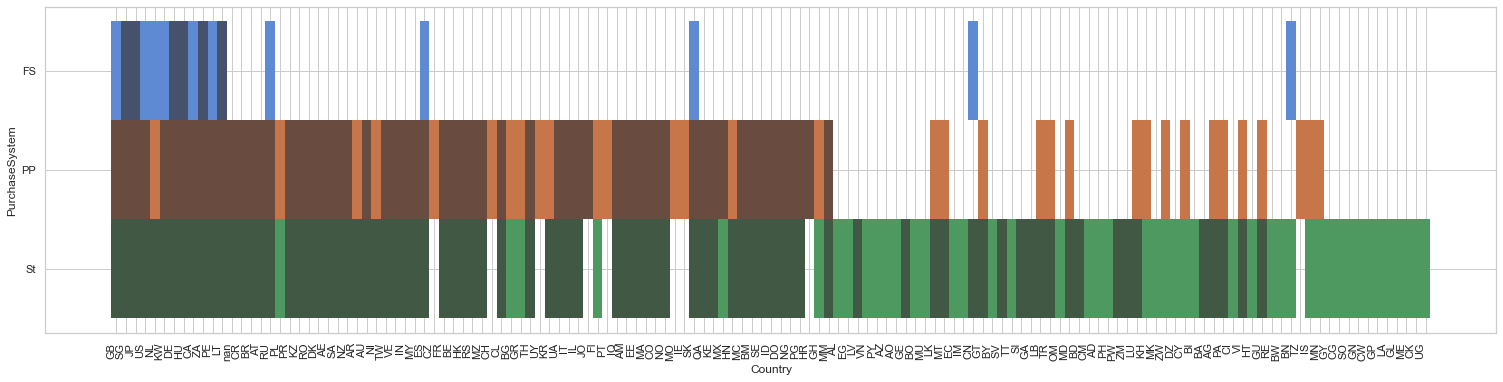

In [655]:
fig, ax = plt.subplots(figsize=(26,6))
sns.histplot(
    data.groupby(['experimentVariant', 'PurchaseSystem', 'Country']).PurchaseAmount.agg('mean').reset_index(), 
    x="Country", y="PurchaseSystem", hue="PurchaseSystem", legend=False, ax=ax
)
xlabels = data.Country.unique()
ax.set_xticklabels(xlabels, rotation=90, ha='right')

Интересный результат! Самая популярная система оплаты в выборке присутствует в большинстве стран, а самая рекдая - в меньшем количестве стран.

Теперь посмотрим на OS!

In [693]:
data.merge(data.groupby(['UserId']).id.size().reset_index().drop(columns='id'), on='UserId').groupby(['experimentVariant', 'OsVersion']).size().reset_index(name='counts')

,experimentVariant,OsVersion,counts
0,control,Microsoft Windows 10 Education,22
1,control,Microsoft Windows 10 Enterprise,105
2,control,Microsoft Windows 10 Enterprise 2016 LTSB,3
3,control,Microsoft Windows 10 Enterprise LTSC,6
4,control,Microsoft Windows 10 Enterprise N,1
...,...,...,...
137,test,Майкрософт Windows 10 Корпоративная LTSC,7
138,test,Майкрософт Windows 10 для образовательных учре...,2
139,test,Майкрософт Windows 8.1 Корпоративная,2
140,test,Майкрософт Windows 8.1 Профессиональная,3


Text(0.5, 1.0, 'Количество юзеров по OS в каждой группе')

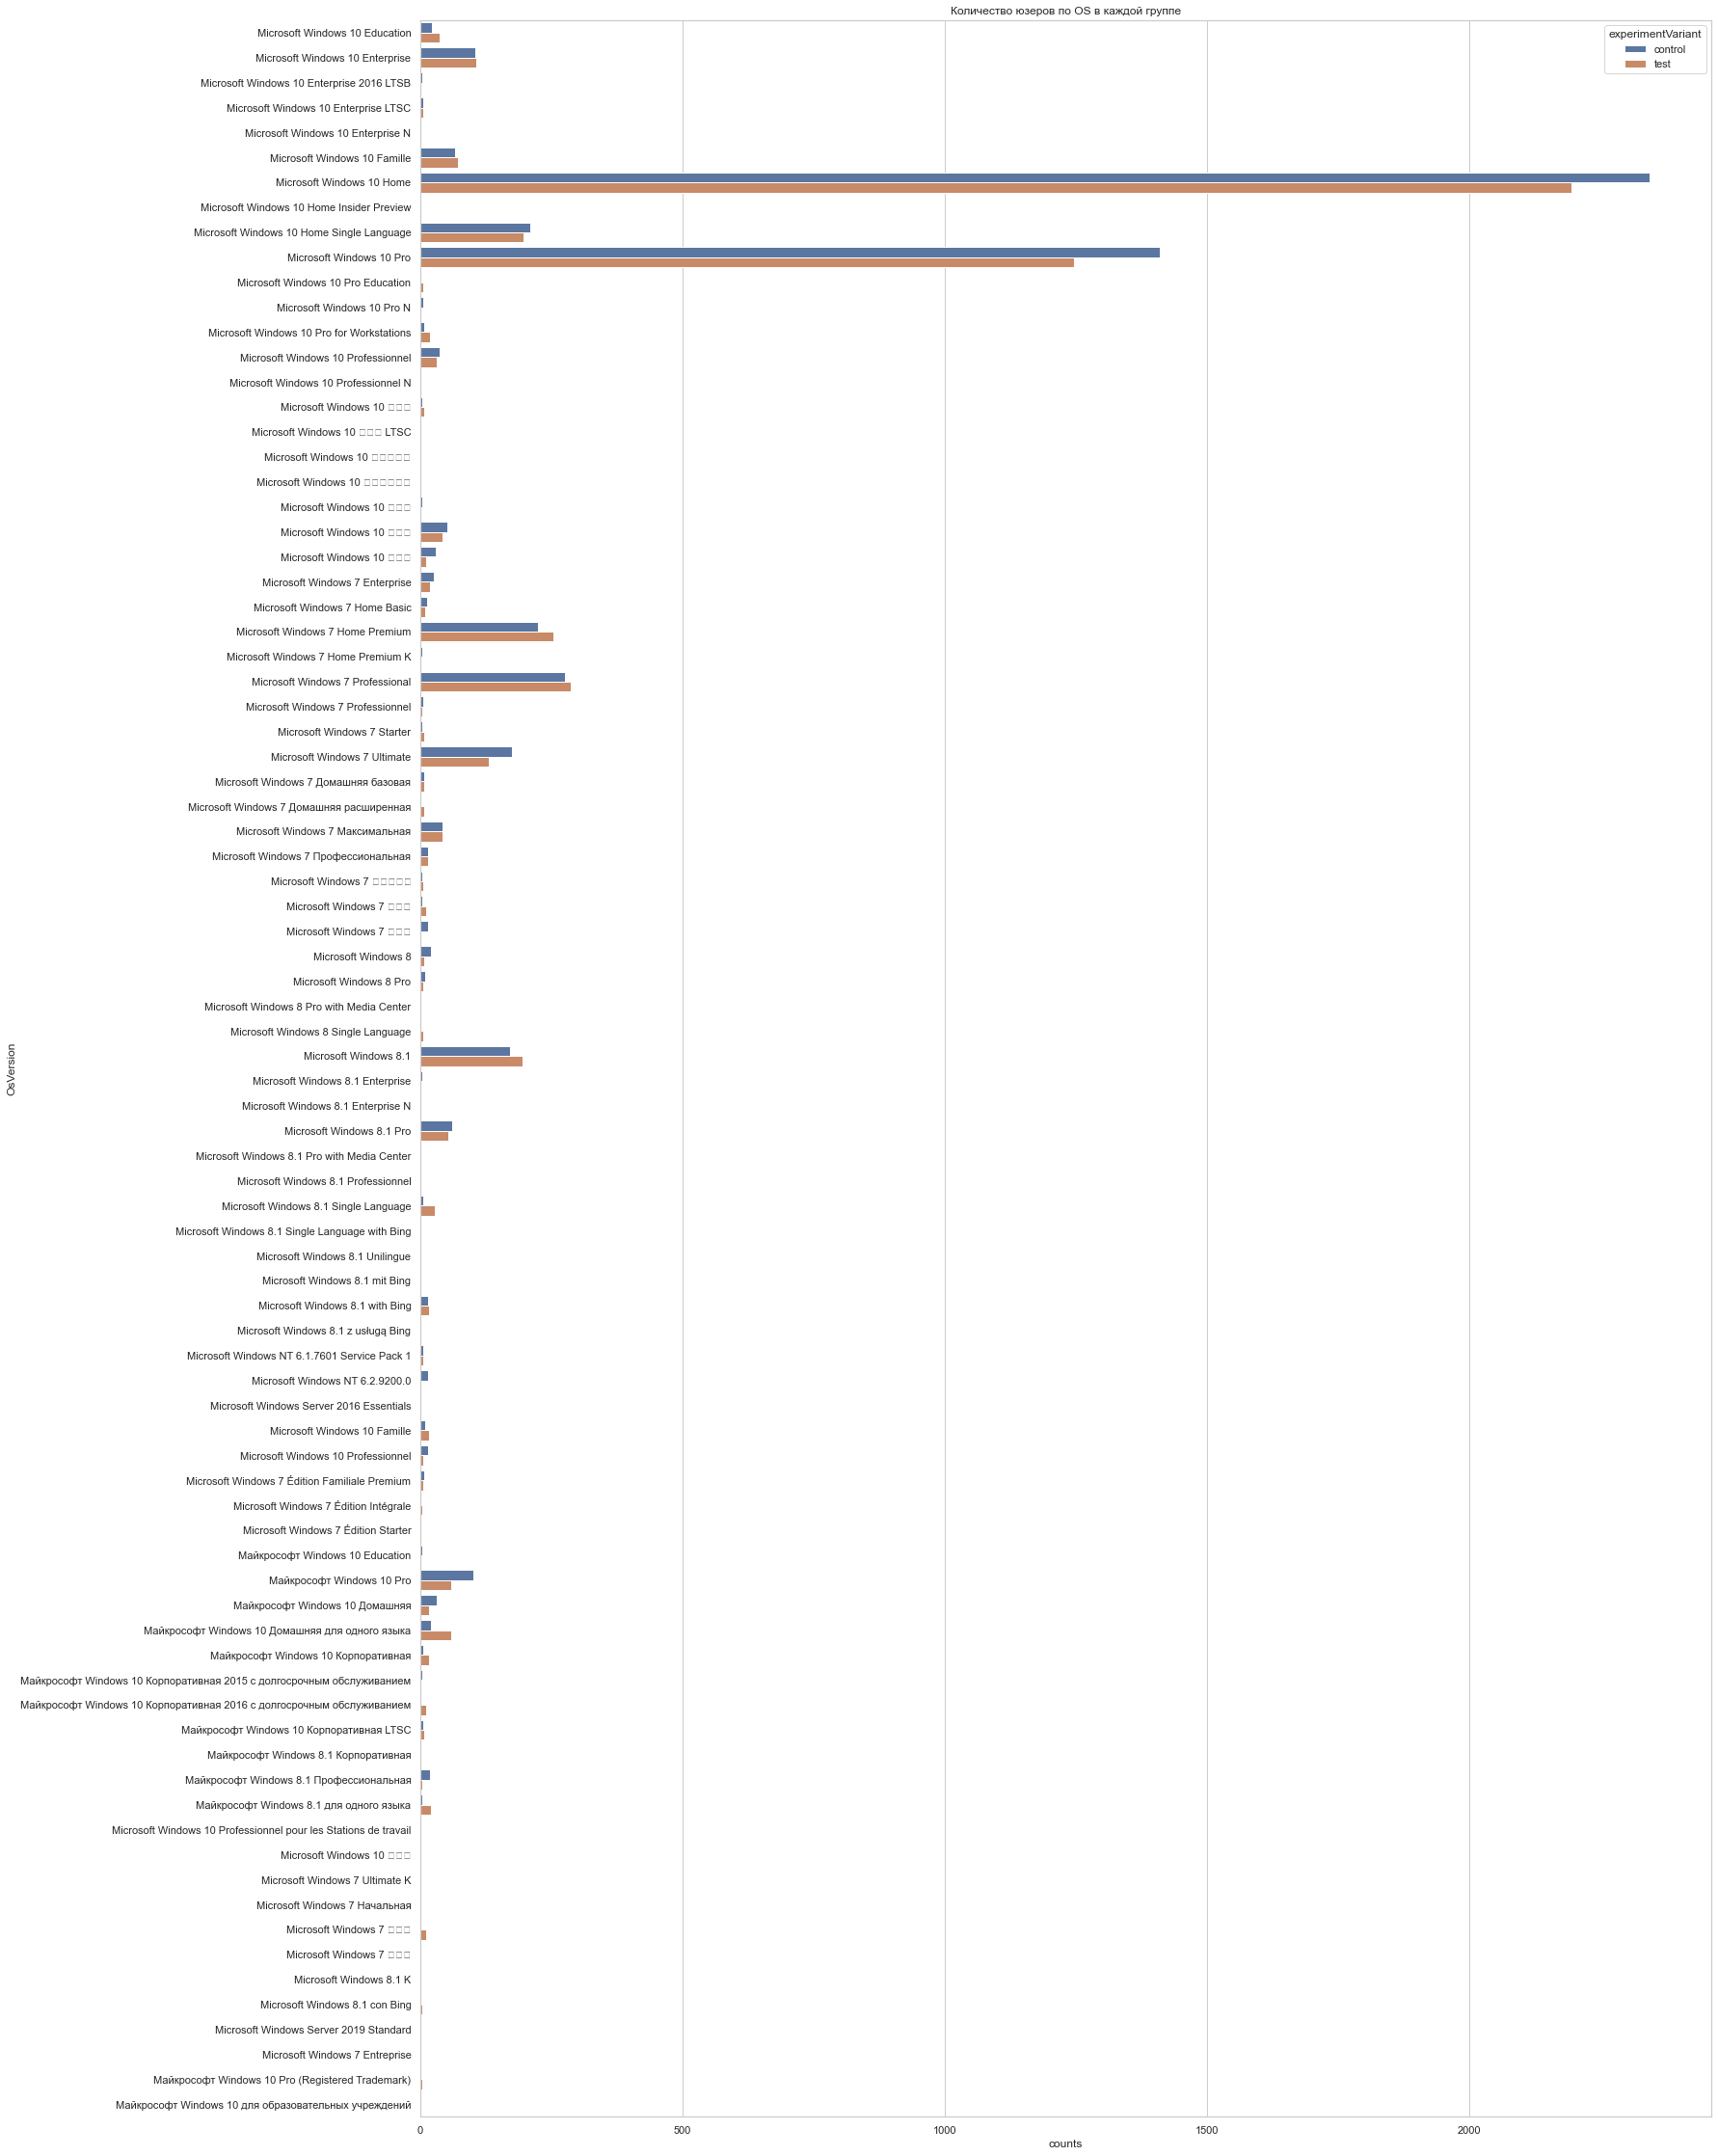

In [694]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(24,40))
sns.barplot(x="counts", y="OsVersion", hue='experimentVariant',
                 data=data.merge(data.groupby(['UserId']).id.size().reset_index().drop(columns='id'), on='UserId').groupby(['experimentVariant', 'OsVersion']).size().reset_index(name='counts'), 
            dodge=True, saturation=0.7, ax=ax)
ax.set_title('Количество юзеров по OS в каждой группе')

Text(0.5, 1.0, 'Средняя сумма выплат по OS в каждой группе')

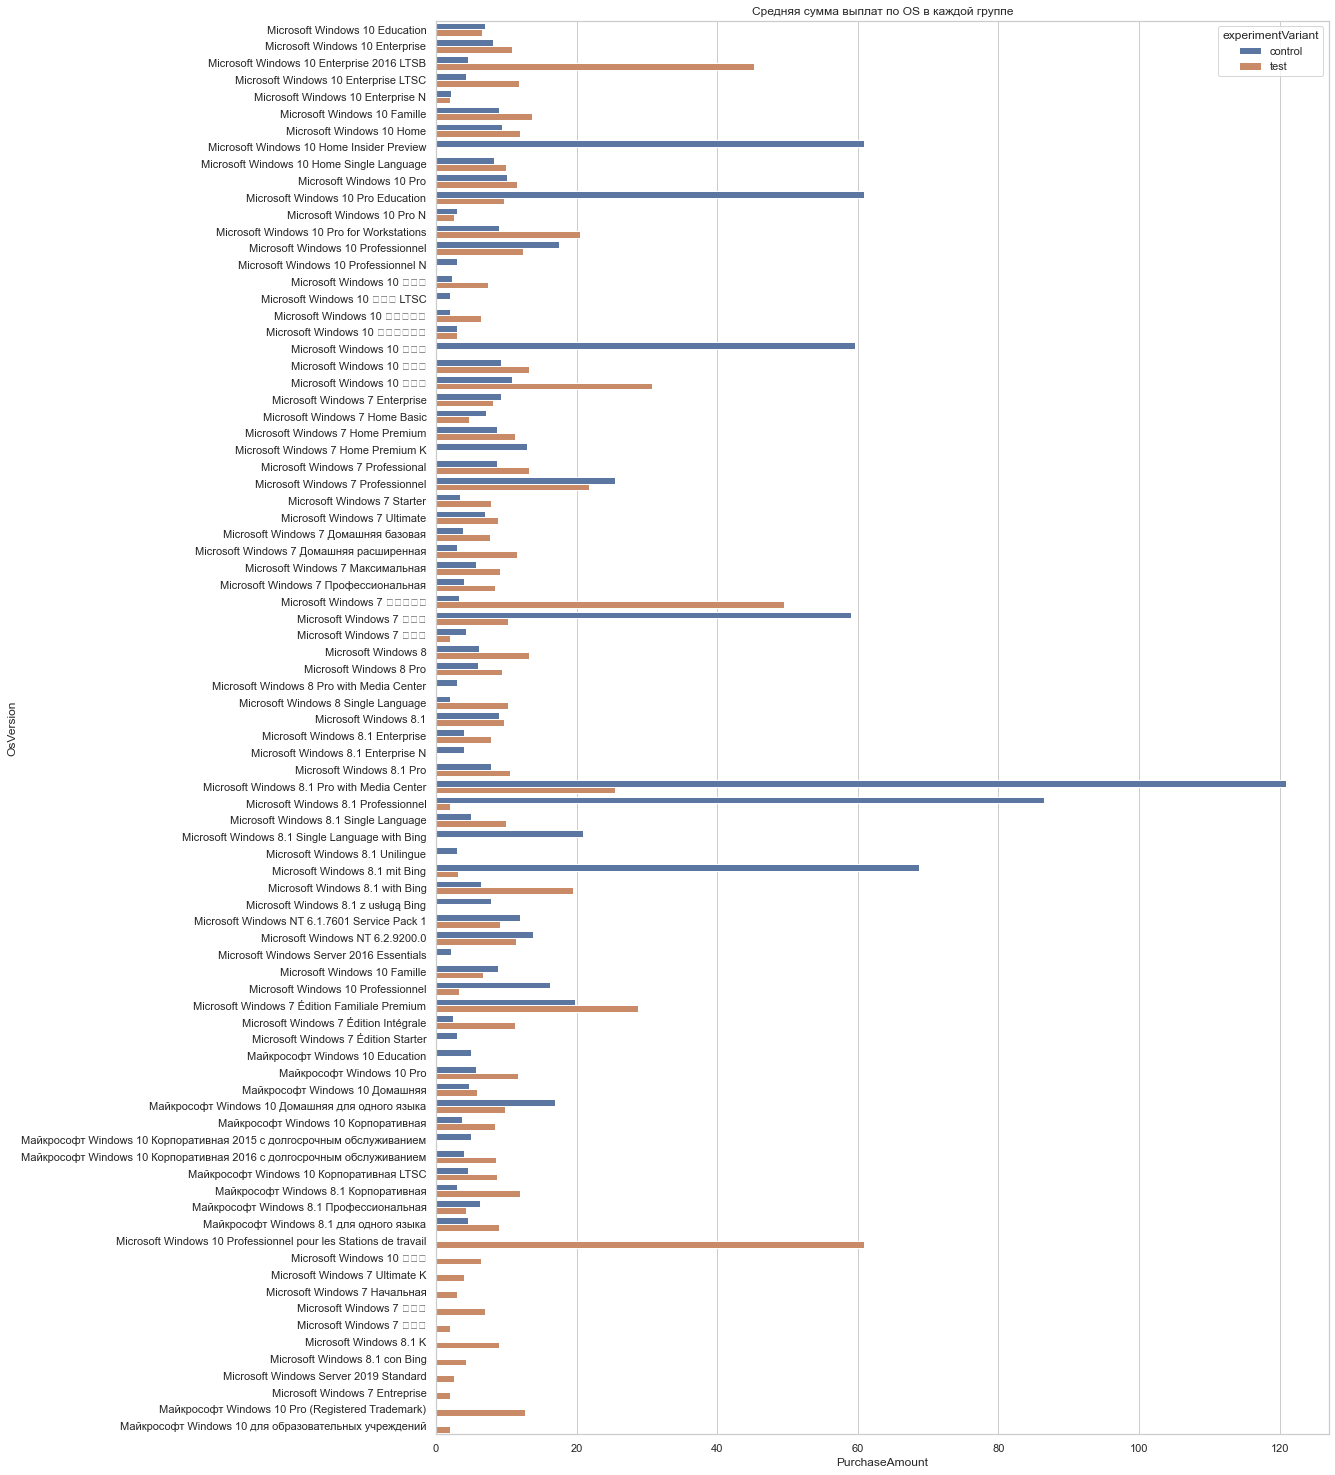

In [695]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(16,26))
sns.barplot(x="PurchaseAmount", y="OsVersion", hue='experimentVariant',
                 data=data.groupby(['experimentVariant', 'OsVersion']).PurchaseAmount.agg('mean').reset_index(), dodge=True, saturation=0.7, ax=ax)
ax.set_title('Средняя сумма выплат по OS в каждой группе')

По самым популярным OS почти нет перекоса средних по сумме выплаты по группам.

Text(0.5, 1.0, 'Медианная сумма выплат по OS в каждой группе')

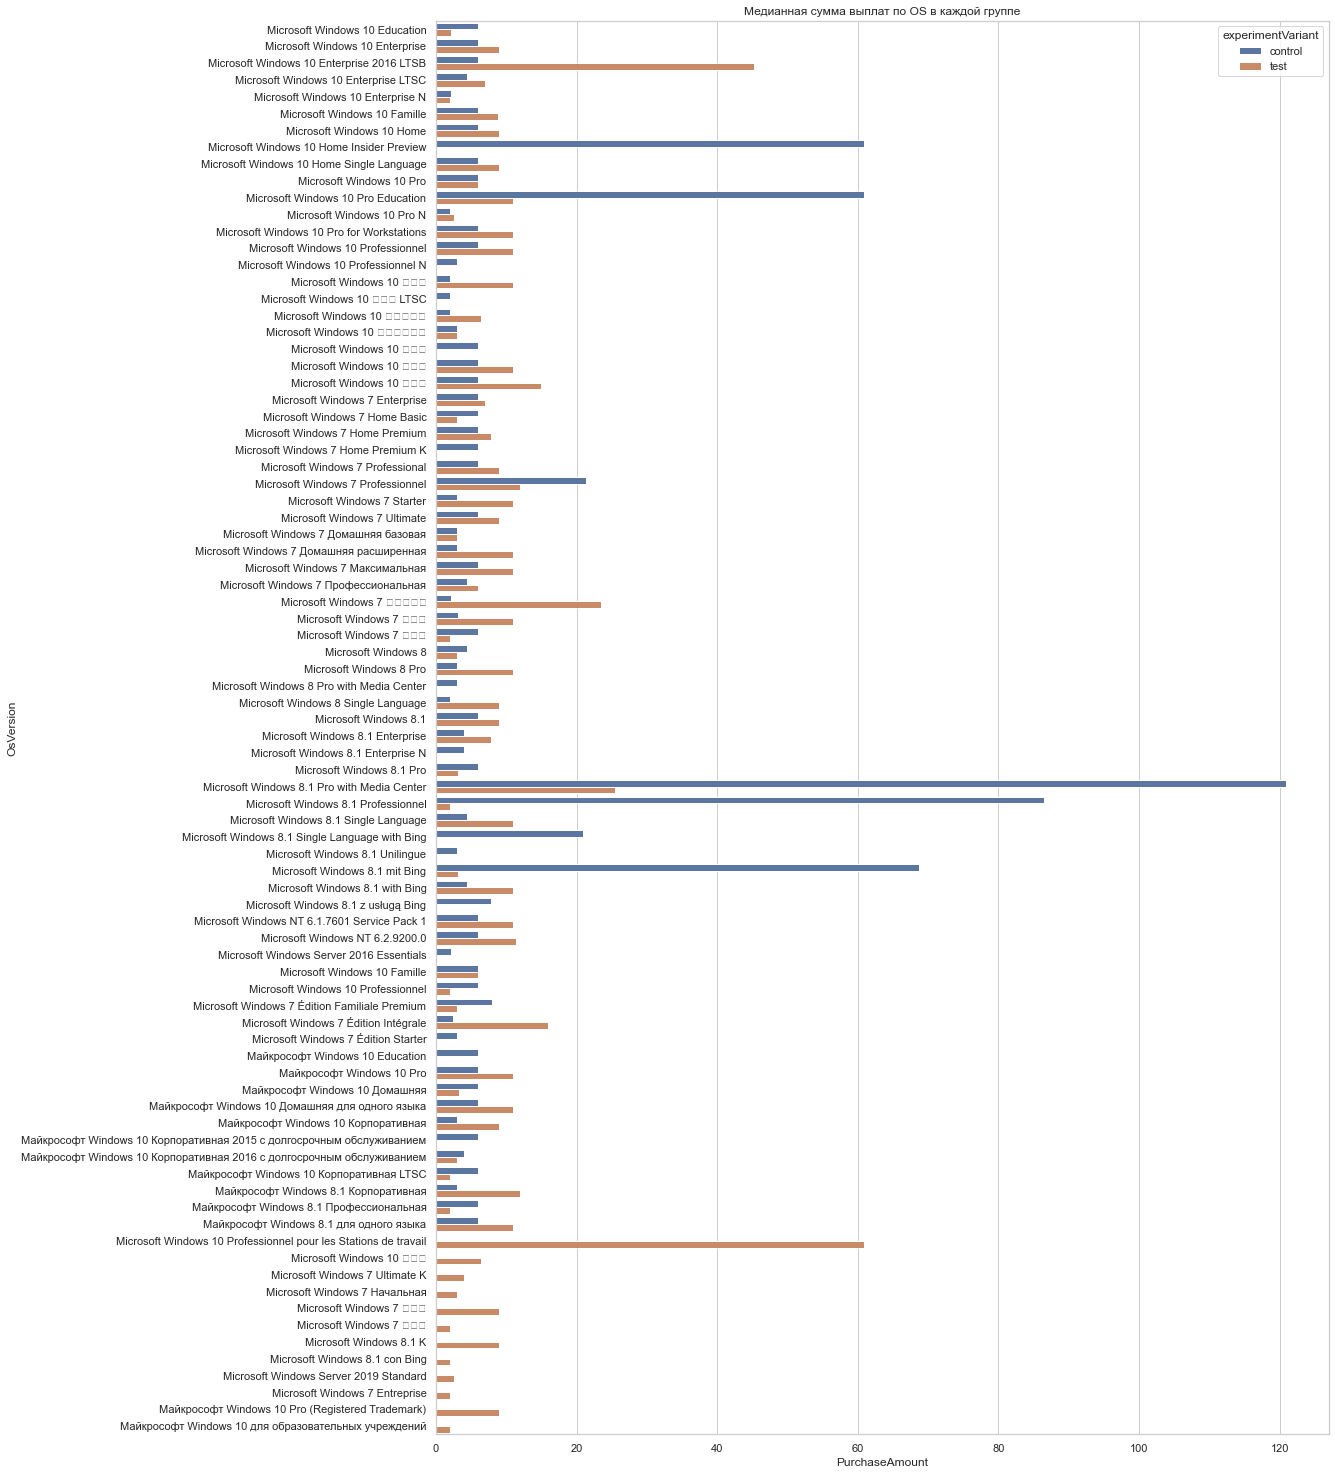

In [696]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(16,26))
sns.barplot(x="PurchaseAmount", y="OsVersion", hue='experimentVariant',
                 data=data.groupby(['experimentVariant', 'OsVersion']).PurchaseAmount.agg('median').reset_index(), dodge=True, saturation=0.7, ax=ax)
ax.set_title('Медианная сумма выплат по OS в каждой группе')

Тоже самое и с медианными значениями.

Всё-таки убедимся, что OS равномерно распределены по группам и не вносят существенный перекос выручки в тестовой группе

In [811]:
r_top = data.merge(data.groupby(['UserId']).id.size().reset_index().drop(columns='id'), on=['UserId']).groupby(['experimentVariant', 'OsVersion']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).groupby(['experimentVariant']).head(20)
r_sum = data.merge(data.groupby(['UserId']).id.size().reset_index().drop(columns='id'), on=['UserId']).groupby(['experimentVariant', 'OsVersion']).PurchaseAmount.agg('sum').reset_index().sort_values(by='PurchaseAmount', ascending=False).groupby(['experimentVariant']).head(20)

t_mean_top = data.merge(r_top, on=['experimentVariant', 'OsVersion']).groupby(['experimentVariant', 'OsVersion']).PurchaseAmount.agg('mean').reset_index()
t_mean_sum = data.merge(r_top, on=['experimentVariant', 'OsVersion']).groupby(['experimentVariant', 'OsVersion']).PurchaseAmount.agg('mean').reset_index()

In [804]:
t_mean_top.head()

,experimentVariant,OsVersion,PurchaseAmount
0,control,Microsoft Windows 10 Education,6.998591
1,control,Microsoft Windows 10 Enterprise,8.075957
2,control,Microsoft Windows 10 Famille,8.932604
3,control,Microsoft Windows 10 Home,9.410897
4,control,Microsoft Windows 10 Home Single Language,8.299510


Text(0.5, 1.0, 'Количество Топ-20 популярных OS по группам')

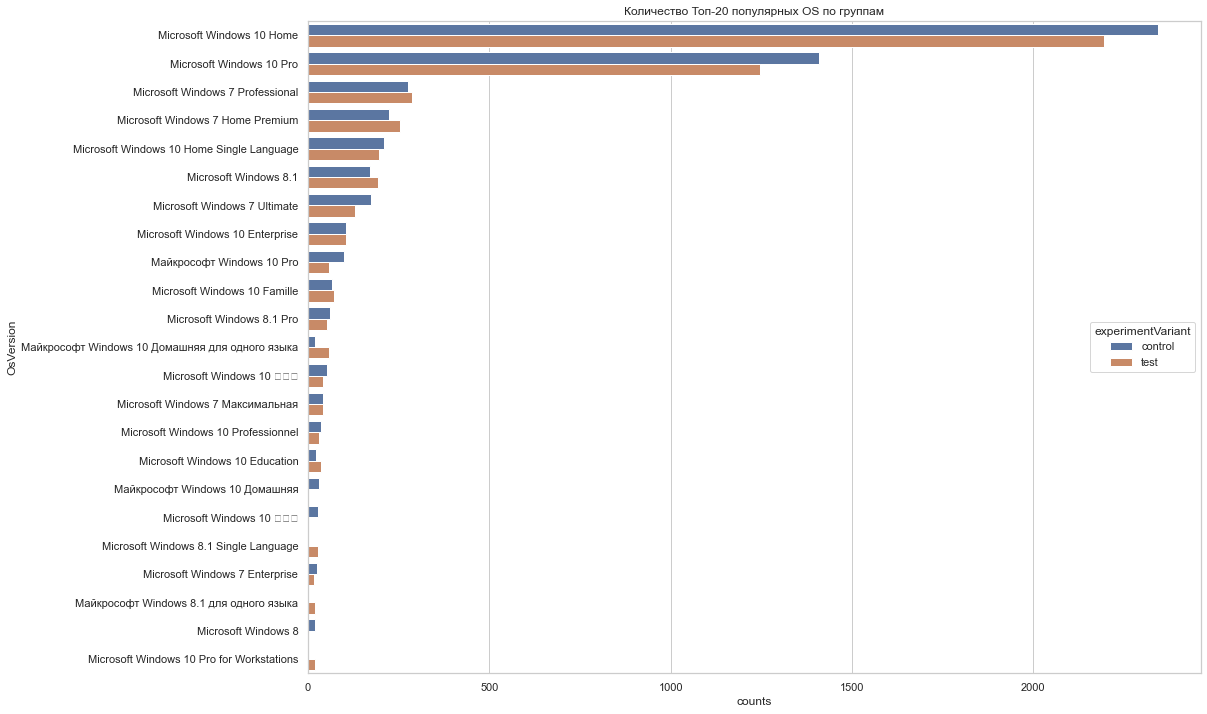

In [809]:
fig, ax = plt.subplots(figsize=(16,12))
sns.barplot(x="counts", y="OsVersion", hue='experimentVariant',
                 data=r_top, dodge=True, saturation=0.7, ax=ax)
ax.set_title('Количество Топ-20 популярных OS по группам')

Text(0.5, 1.0, 'Средние суммы выплат в каждой группе из Топ-20 популярных OS')

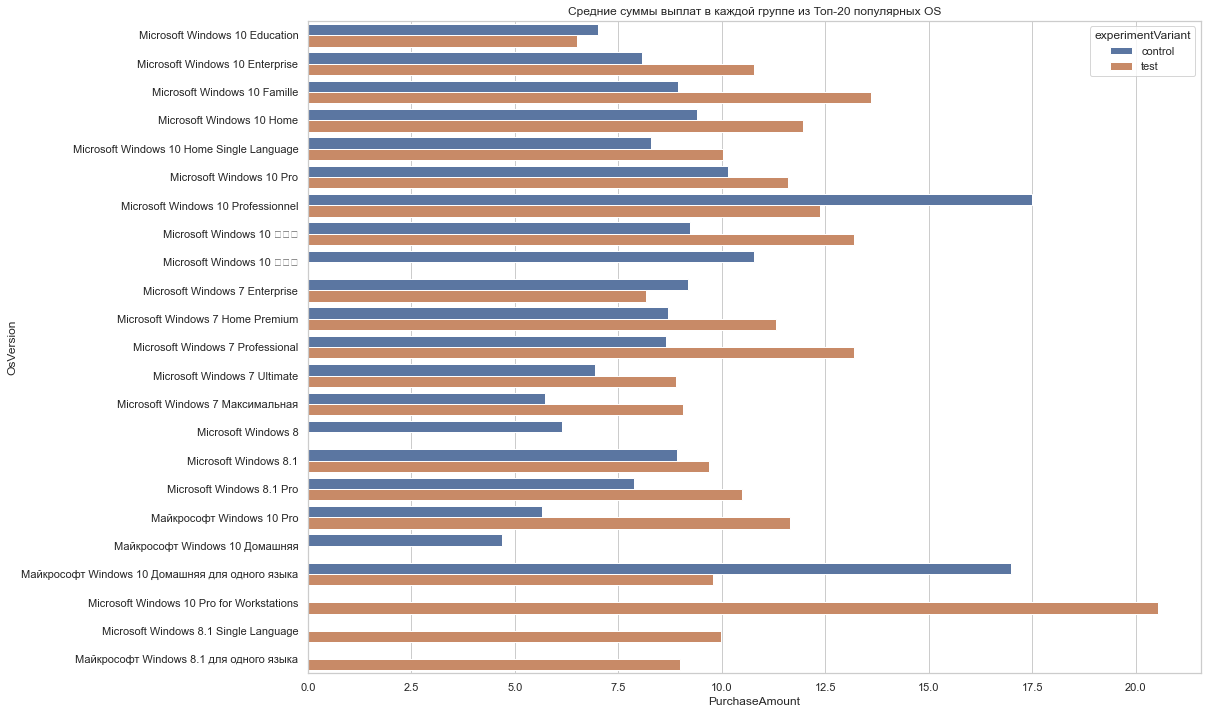

In [810]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(16,12))
sns.barplot(x="PurchaseAmount", y="OsVersion", hue='experimentVariant',
                 data=t_mean_top, dodge=True, saturation=0.7, ax=ax)
ax.set_title('Средние суммы выплат в каждой группе из Топ-20 популярных OS')

Как мы можем видеть, OS особого выигрыша тестовой группе не даёт, т.к. самые популярные OS примерно равнораспределены. Есть небольшая зависимость от OS для средних сумм выплат, но это скорее аномалии.

Text(0.5, 1.0, 'Топ-20 прибыльных OS по группам')

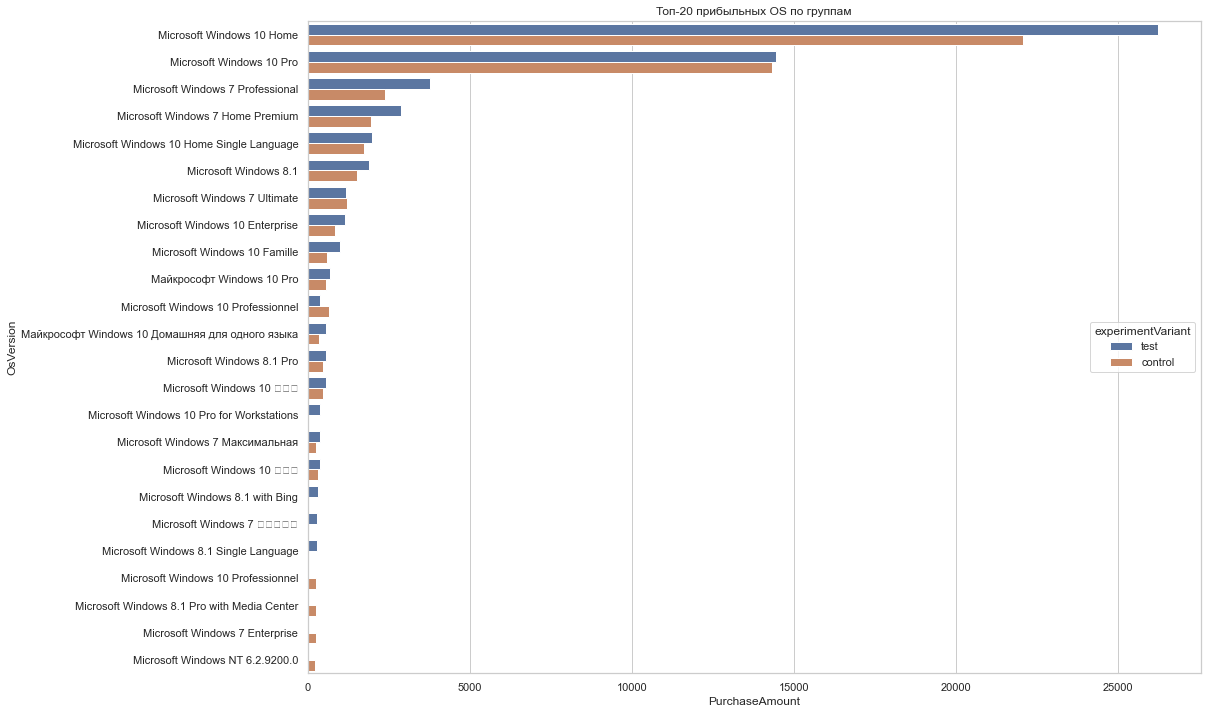

In [814]:
fig, ax = plt.subplots(figsize=(16,12))
sns.barplot(x="PurchaseAmount", y="OsVersion", hue='experimentVariant',
                 data=r_sum, dodge=True, saturation=0.7, ax=ax)
ax.set_title('Топ-20 прибыльных OS по группам')

Text(0.5, 1.0, 'Средние суммы выплат в каждой группе из Топ-20 по выручке OS')

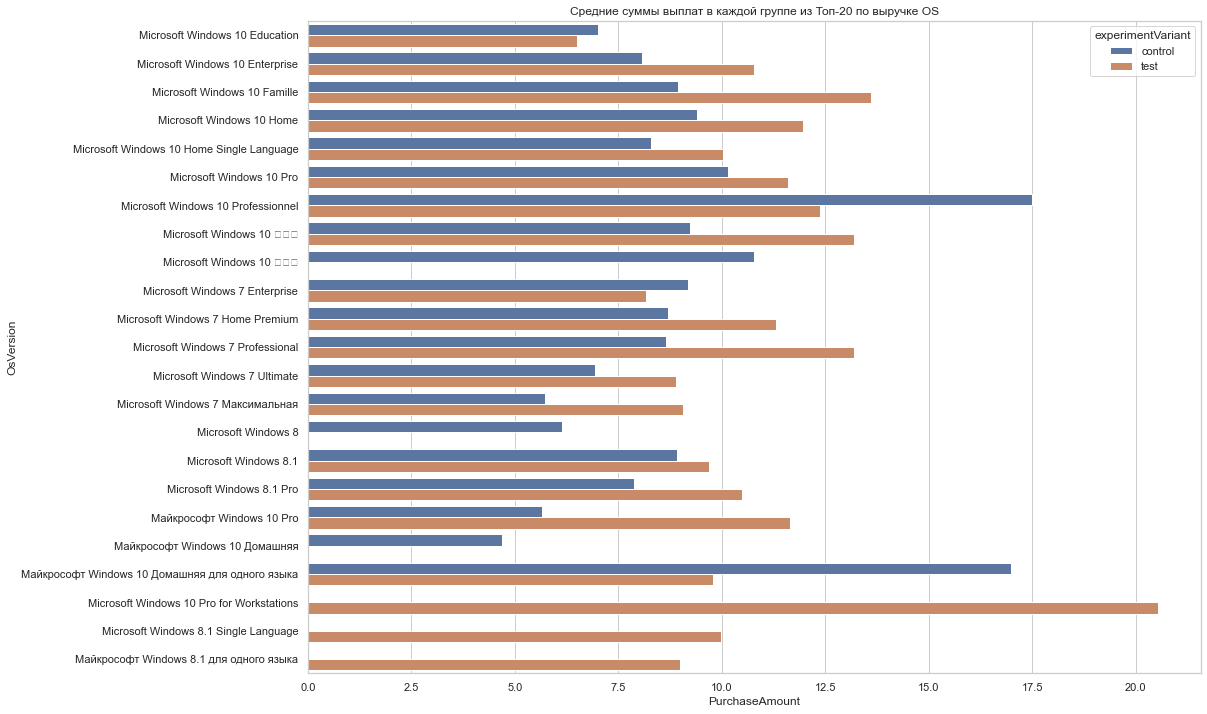

In [825]:
fig, ax = plt.subplots(figsize=(16,12))
sns.barplot(x="PurchaseAmount", y="OsVersion", hue='experimentVariant',
                 data=t_mean_sum, dodge=True, saturation=0.7, ax=ax)
ax.set_title('Средние суммы выплат в каждой группе из Топ-20 по выручке OS')

Убедились, что OS слабо влияет на среднюю сумму выплат по группам 

Посмотрим ещё на распределение стран по группам

[Text(0, 0, 'GB'),
 Text(1, 0, 'SG'),
 Text(2, 0, 'JP'),
 Text(3, 0, 'US'),
 Text(4, 0, 'NL'),
 Text(5, 0, 'KW'),
 Text(6, 0, 'DE'),
 Text(7, 0, 'HU'),
 Text(8, 0, 'CA'),
 Text(9, 0, 'ZA'),
 Text(10, 0, 'PE'),
 Text(11, 0, 'LT'),
 Text(12, 0, 'nan'),
 Text(13, 0, 'CR'),
 Text(14, 0, 'BR'),
 Text(15, 0, 'AT'),
 Text(16, 0, 'RU'),
 Text(17, 0, 'PL'),
 Text(18, 0, 'PR'),
 Text(19, 0, 'KZ'),
 Text(20, 0, 'RO'),
 Text(21, 0, 'DK'),
 Text(22, 0, 'AE'),
 Text(23, 0, 'SA'),
 Text(24, 0, 'NZ'),
 Text(25, 0, 'AR'),
 Text(26, 0, 'AU'),
 Text(27, 0, 'NI'),
 Text(28, 0, 'TW'),
 Text(29, 0, 'VE'),
 Text(30, 0, 'IN'),
 Text(31, 0, 'MY'),
 Text(32, 0, 'ES'),
 Text(33, 0, 'CZ'),
 Text(34, 0, 'FR'),
 Text(35, 0, 'BE'),
 Text(36, 0, 'HK'),
 Text(37, 0, 'RS'),
 Text(38, 0, 'MZ'),
 Text(39, 0, 'CH'),
 Text(40, 0, 'CL'),
 Text(41, 0, 'BG'),
 Text(42, 0, 'GR'),
 Text(43, 0, 'TH'),
 Text(44, 0, 'UY'),
 Text(45, 0, 'KR'),
 Text(46, 0, 'UA'),
 Text(47, 0, 'IT'),
 Text(48, 0, 'IL'),
 Text(49, 0, 'JO'),
 Text(50,

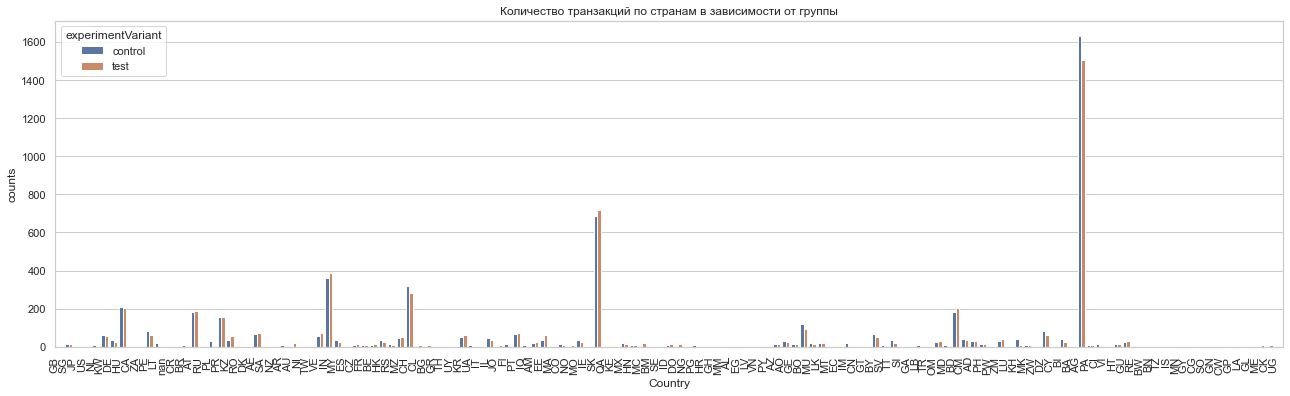

In [818]:
fig, ax = plt.subplots(figsize=(22,6))
sns.barplot(x="Country", y="counts", hue='experimentVariant',
                 data=data.groupby(['experimentVariant', 'Country']).size().reset_index(name='counts'), dodge=True, saturation=0.7, ax=ax)
ax.set_title('Количество транзакций по странам в зависимости от группы')
xlabels = data.Country.unique()[:-1]
ax.set_xticklabels(xlabels, rotation=90, ha='right')

Видно, что большинство стран почти равномерно распеределены по группам. Значит они вряд ли вносят вклад в разницу средних.

Посмотрим на выручку по группам и по веткам

Text(0.5, 1.0, 'Медианные значения PurchaseAmount по группам')

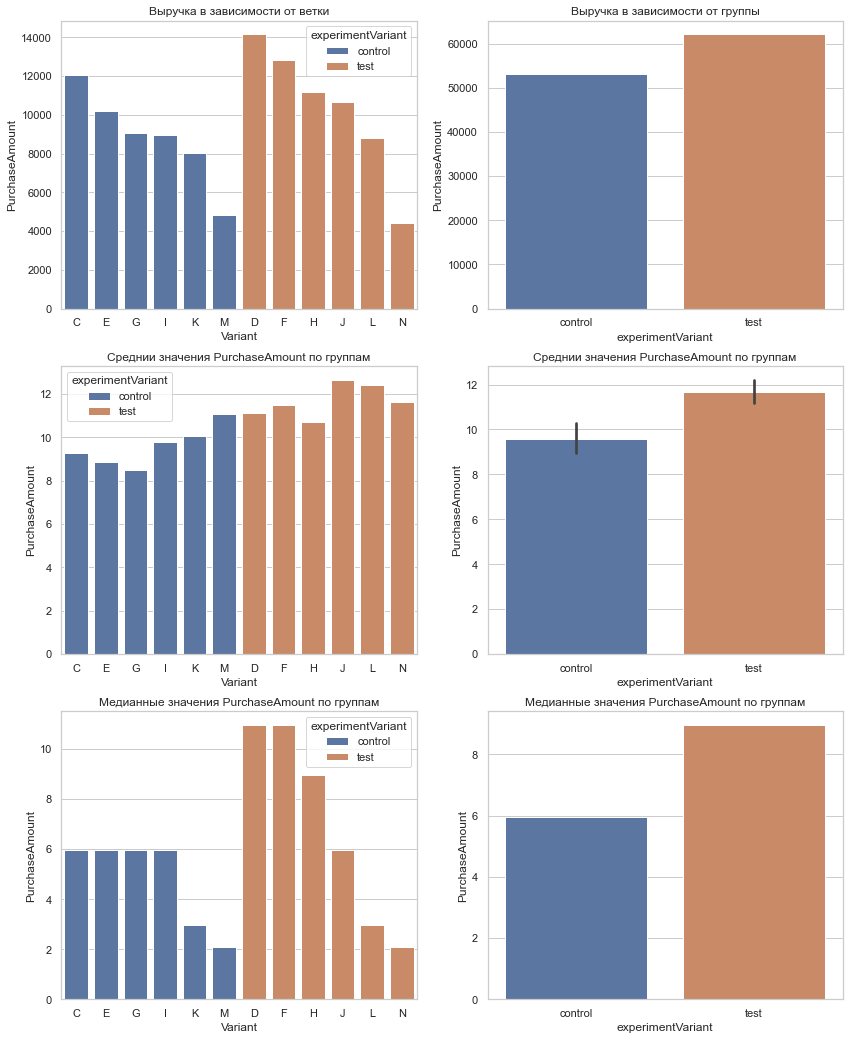

In [822]:
fig, ax = plt.subplots(3,2,figsize=(14,18))
sns.barplot(x="Variant", y="PurchaseAmount", hue='experimentVariant',
                 data=data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('sum').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[0][0])
sns.barplot(x="experimentVariant", y="PurchaseAmount", 
                 data=data.groupby(['experimentVariant']).PurchaseAmount.agg('sum').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[0][1])
ax[0][0].set_title('Выручка в зависимости от ветки')
ax[0][1].set_title('Выручка в зависимости от группы')

sns.barplot(x="Variant", y="PurchaseAmount", hue="experimentVariant",
                 data=data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('mean').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[1][0])
sns.barplot(x="Variant", y="PurchaseAmount", hue="experimentVariant",
                 data=data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('median').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[2][0])

sns.barplot(x="experimentVariant", y="PurchaseAmount", 
                 data=data.groupby(['experimentVariant', 'Variant']).PurchaseAmount.agg('mean').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[1][1])
sns.barplot(x="experimentVariant", y="PurchaseAmount", 
                 data=data.groupby(['experimentVariant']).PurchaseAmount.agg('median').reset_index(), 
            dodge=False, saturation=0.7, ax=ax[2][1])

ax[1][0].set_title('Среднии значения PurchaseAmount по группам')
ax[2][0].set_title('Медианные значения PurchaseAmount по группам')
ax[1][1].set_title('Среднии значения PurchaseAmount по группам')
ax[2][1].set_title('Медианные значения PurchaseAmount по группам')

In [842]:
df = data.merge(data.groupby(['experimentVariant']).PurchaseAmount.agg('mean').reset_index(name='PA_mean'), on='experimentVariant')

ana = ols('PurchaseAmount ~ Country + OsVersion + PurchaseSystem', data=data).fit()
anova_lm(ana, tip=2)

,df,sum_sq,mean_sq,F,PR(>F)
Country,136.0,6.404362e+04,470.908973,1.877293,3.701554e-09
OsVersion,83.0,6.538968e+04,787.827438,3.140698,6.658473e-20
PurchaseSystem,2.0,1.727370e+03,863.684950,3.443106,3.200094e-02
Residual,10619.0,2.663720e+06,250.844726,NaN,NaN


Приближаемся к выводу

Попробуем агригировать по дате и смотреть выручку по группам. Проверим гипотезу, что средняя выручка в тестовой группе статистически значимо отличается от средней выручки в контрольной группе

In [886]:
df = data.merge(data.groupby(['Date', 'experimentVariant']).PurchaseAmount.agg('sum').reset_index(name='PA_sum'), on = ['Date', 'experimentVariant'])

<AxesSubplot:xlabel='PA_sum', ylabel='Count'>

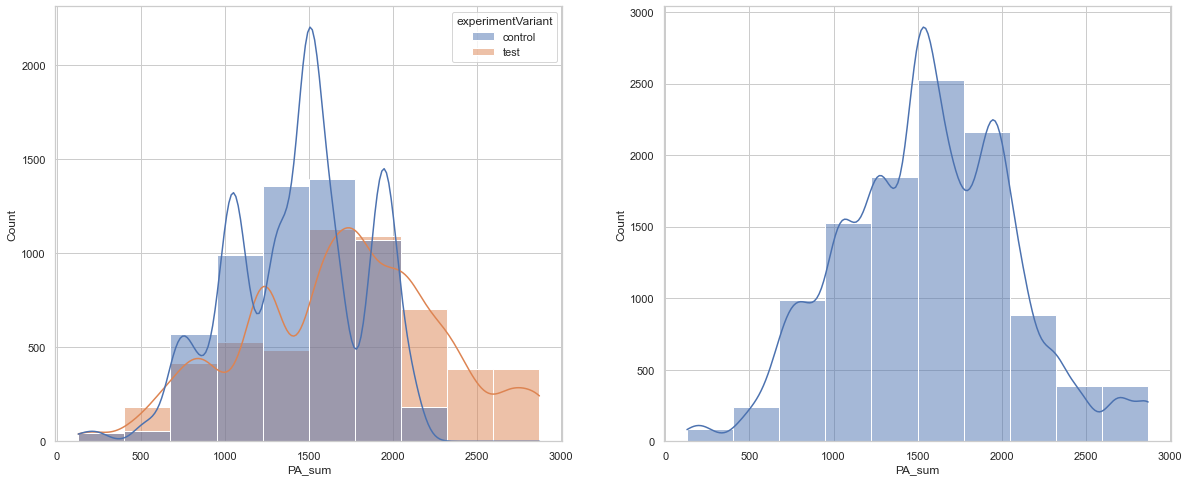

In [854]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data=df, x='PA_sum', hue='experimentVariant', bins=10, kde=True, ax=ax[0])
sns.histplot(data=df, x='PA_sum', kde=True, bins=10, ax=ax[1])

Text(0.5, 1.0, 'test')

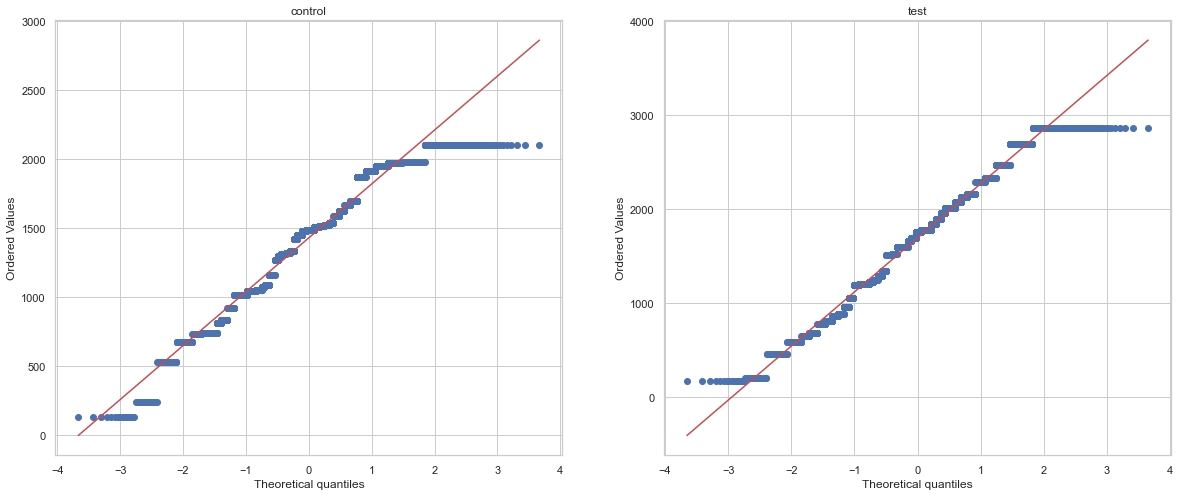

In [857]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
stats.probplot(df[df.experimentVariant == 'control'].PA_sum, dist="norm", plot=ax[0])
stats.probplot(df[df.experimentVariant == 'test'].PA_sum, dist="norm", plot=ax[1])
ax[0].set_title('control')
ax[1].set_title('test')

In [858]:
print("Control group")
stat, p = stats.normaltest(df[df.experimentVariant == 'control'].PA_sum) # Критерий согласия Пирсона
print("Statistics=%.3f, p-value=%.3f" % (stat, p))
if p > 0.05:
    print('Принять гипотезу о нормальности')
else:
    print("Отклонить гипотезу о нормальности\n")
    
print("Test group")
stat, p = stats.normaltest(df[df.experimentVariant == 'test'].PA_sum) # Критерий согласия Пирсона
print("Statistics=%.3f, p-value=%.3f" % (stat, p))
if p > 0.05:
    print('Принять гипотезу о нормальности')
else:
    print("Отклонить гипотезу о нормальности\n")

Control group
Statistics=150.920, p-value=0.000
Отклонить гипотезу о нормальности

Test group
Statistics=67.845, p-value=0.000
Отклонить гипотезу о нормальности



Мы можем отбросить хвосты и сказать, что это аномалии, и они не значимы, но это ведь не так...

In [860]:
stats.levene(df[df.experimentVariant == 'control'].PA_sum, df[df.experimentVariant == 'test'].PA_sum)

LeveneResult(statistic=646.8198926513635, pvalue=1.0402271703397743e-138)

Снова никакой нормальности и гомогенности!

In [862]:
print(rp.summary_cont(df[df.experimentVariant == 'control'].PA_sum))
print(rp.summary_cont(df[df.experimentVariant == 'test'].PA_sum))



  Variable       N       Mean        SD      SE  95% Conf.   Interval
0   PA_sum  5671.0  1430.4823  397.4476  5.2778  1420.1359  1440.8288


  Variable       N      Mean        SD     SE  95% Conf.   Interval
0   PA_sum  5361.0  1695.824  579.7495  7.918  1680.3015  1711.3466


Ну попробуем отбросить хвост и оставим 2sd с двух сторон от средних

In [868]:
df1 = df[(df.experimentVariant == 'control') & (df.PA_sum <= 2225) & (df.PA_sum >= 635)]
df2 = df[(df.experimentVariant == 'test') & (df.PA_sum <= 2755) & (df.PA_sum >= 635)]

In [869]:
print("Control group")
stat, p = stats.normaltest(df1[df1.experimentVariant == 'control'].PA_sum) # Критерий согласия Пирсона
print("Statistics=%.3f, p-value=%.3f" % (stat, p))
if p > 0.05:
    print('Принять гипотезу о нормальности')
else:
    print("Отклонить гипотезу о нормальности\n")
    
print("Test group")
stat, p = stats.normaltest(df2[df2.experimentVariant == 'test'].PA_sum) # Критерий согласия Пирсона
print("Statistics=%.3f, p-value=%.3f" % (stat, p))
if p > 0.05:
    print('Принять гипотезу о нормальности')
else:
    print("Отклонить гипотезу о нормальности\n")

Control group
Statistics=536.564, p-value=0.000
Отклонить гипотезу о нормальности

Test group
Statistics=220.141, p-value=0.000
Отклонить гипотезу о нормальности



In [871]:
print("Control ",rp.summary_cont(df1[df1.experimentVariant == 'control'].PA_sum))
print("Test ", rp.summary_cont(df2[df2.experimentVariant == 'test'].PA_sum))



Control    Variable       N       Mean        SD      SE  95% Conf.   Interval
0   PA_sum  5571.0  1449.2528  374.5656  5.0184  1439.4149  1459.0908


Test    Variable       N      Mean        SD      SE  95% Conf.   Interval
0   PA_sum  5002.0  1696.373  503.8504  7.1241  1682.4066  1710.3393


Text(0.5, 1.0, 'test')

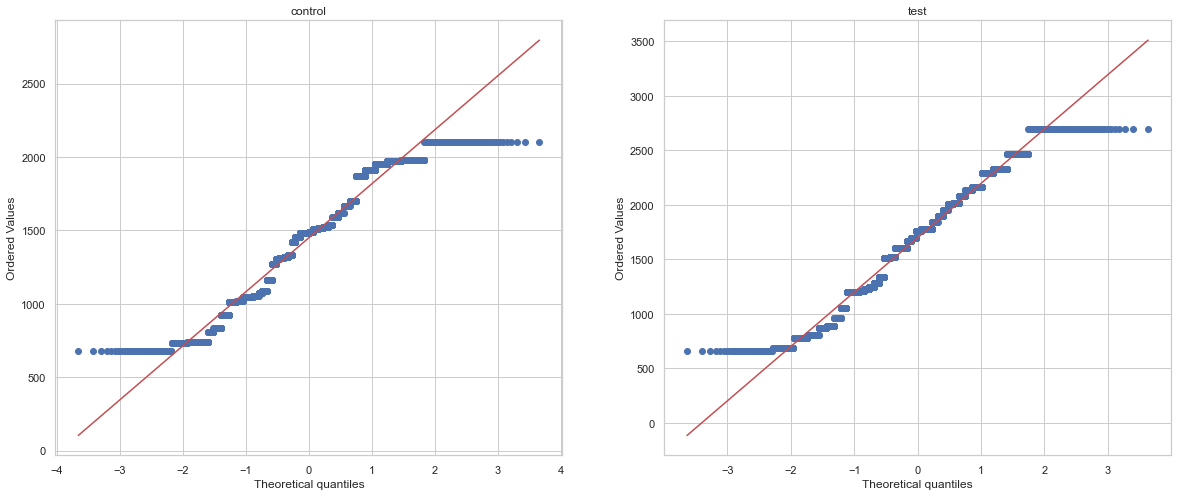

In [872]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
stats.probplot(df1[df1.experimentVariant == 'control'].PA_sum, dist="norm", plot=ax[0])
stats.probplot(df2[df2.experimentVariant == 'test'].PA_sum, dist="norm", plot=ax[1])
ax[0].set_title('control')
ax[1].set_title('test')

<AxesSubplot:xlabel='PA_sum', ylabel='Count'>

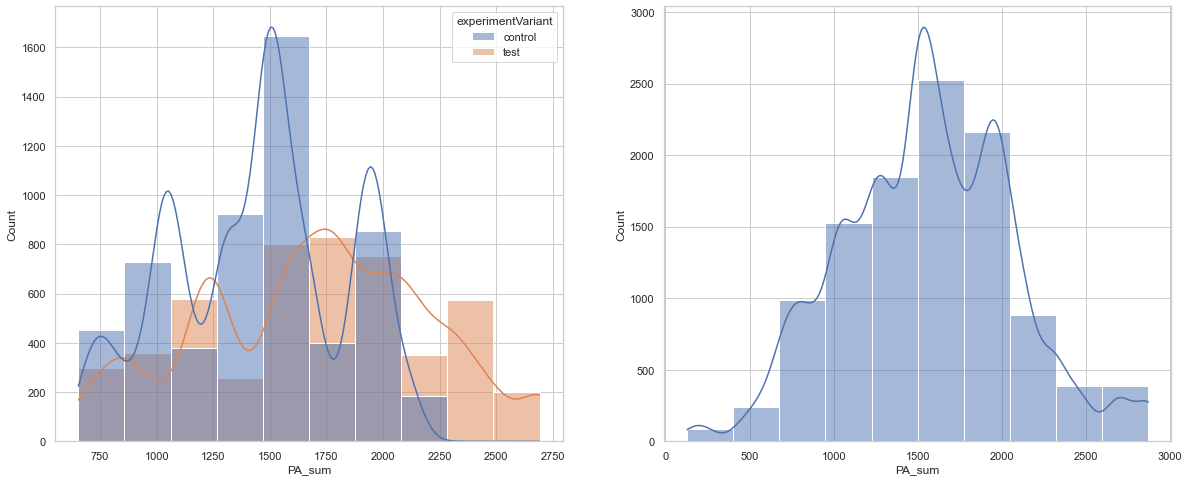

In [876]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data=df1.append(df2, ignore_index=True), x='PA_sum', hue='experimentVariant', bins=10, kde=True, ax=ax[0])
sns.histplot(data=df, x='PA_sum', kde=True, bins=10, ax=ax[1])

После обрезания лучше не стало

In [877]:
stats.kruskal(df[df.experimentVariant == 'control'].PA_sum, df[df.experimentVariant == 'test'].PA_sum)

KruskalResult(statistic=758.6869353319827, pvalue=5.182788068972083e-167)

In [878]:
stats.kruskal(df1[df1.experimentVariant == 'control'].PA_sum, df2[df2.experimentVariant == 'test'].PA_sum)

KruskalResult(statistic=759.694713114375, pvalue=3.1292466108026698e-167)

Как видно, группы статистически значимо отличаются средней суммой выплат 

In [894]:
ana = ols('PA_sum ~ experimentVariant + Country + OsVersion + PurchaseSystem', data=df).fit()
anova_lm(ana, tip=2)

,df,sum_sq,mean_sq,F,PR(>F)
experimentVariant,1.0,1.926506e+08,1.926506e+08,793.967160,1.588486e-168
Country,136.0,4.609282e+07,3.389178e+05,1.396775,1.677472e-03
OsVersion,83.0,2.060287e+07,2.482274e+05,1.023015,4.216687e-01
PurchaseSystem,2.0,8.324759e+06,4.162380e+06,17.154333,3.647355e-08
Residual,10618.0,2.576384e+09,2.426430e+05,NaN,NaN


Как можно увидеть, что есть статистические различия признаков. Осталось проверить значимость в совокупности

In [915]:
ana = ols('PA_sum ~ experimentVariant*OsVersion*PurchaseSystem', data=df).fit()
anova_lm(ana, tip=3)

,df,sum_sq,mean_sq,F,PR(>F)
experimentVariant,1.0,1.940270e+08,1.940270e+08,795.556196,5.939732e-169
OsVersion,83.0,2.191929e+07,2.640879e+05,1.082822,2.849446e-01
PurchaseSystem,2.0,8.801066e+06,4.400533e+06,18.043214,1.503072e-08
experimentVariant:OsVersion,83.0,4.598098e+07,5.539877e+05,2.271479,4.566162e-10
experimentVariant:PurchaseSystem,2.0,2.149421e+05,1.074710e+05,0.440656,6.436254e-01
OsVersion:PurchaseSystem,166.0,1.622962e+08,9.776881e+05,4.008750,1.488059e-58
experimentVariant:OsVersion:PurchaseSystem,166.0,1.548222e+08,9.326641e+05,3.824141,7.460603e-54
Residual,10812.0,2.636923e+09,2.438885e+05,NaN,NaN


Убедились в прошлых выводах.

Text(0.5, 1.0, 'Выручка с транзакций в зависимости от группы')

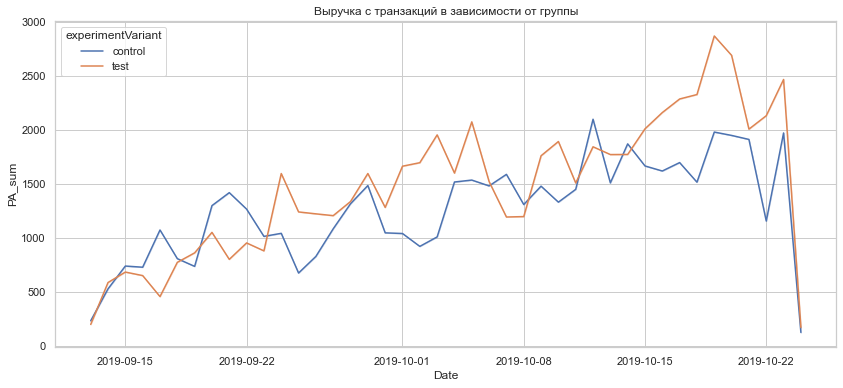

In [892]:
fig, ax = plt.subplots(figsize=(14,6))
sns.lineplot(x="Date", y="PA_sum", hue='experimentVariant',
                 data=df, ax=ax)
ax.set_title('Выручка с транзакций в зависимости от группы')

Вывод:

Получается, что с увеличением цены за подписку в тестовой группе увеличиваются не только средняя и медианная цены покупок, но и выручка за всё время эксперимента. Был проведён анализ где было выяснено, что другие признаки не влияли статистически значимо на результат, поэтому можно сделать вывод, что изначальная гипотеза верна: заработаем больше денех.